# Multi-agent Collaboration


## Overview

A single agent can usually perform well using a small set of tools to solve a specific task. However, even powerful models like GPT-4 may struggle when given many different tools to solve a complex task.

One way to approach complicated tasks is through a _"divide-and-conquer"_ approach. Create a specialized agent for each task and route tasks to the correct _"expert"_.

The code from this notebook is adapted from the [LangGraph tutorial](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/multi-agent-collaboration). The ideas in this notebook is inspired by the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155), by Wu, et. al.

The graph that we'll build will look something like the following diagram:

![multi_agent diagram](img/simple_multi_agent_diagram.png)

**Figure 1**: Image from [LangGraph](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/multi-agent-collaboration)

## Setup

Before we begin, please make sure you have setup the `.env` file in the project 
directory as described in [`README.md`](README.md).

Next, we will load in the necessary environment variables (e.g., API keys) for this notebook:

In [1]:
import os
from dotenv import load_dotenv

_ = load_dotenv()

assert os.environ.get("GOOGLE_API_KEY")
assert os.environ.get("TAVILY_API_KEY")

## Create Agents

The following helper function will help create agents. These agents will then be nodes in the graph.

In [2]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import (
    ChatPromptTemplate, 
    MessagesPlaceholder,
)
from langchain_core.language_models.chat_models import BaseChatModel
from langchain_core.tools import BaseTool
from langchain_core.runnables import RunnableSequence


def create_agent(
    model: BaseChatModel, 
    tools: list[BaseTool], 
    system_message: str
) -> RunnableSequence:
    """
    Create an agent that will be a node in the graph.

    Args:
        model: The LLM that powers this agent.
        tools: List of tools to be called by the LLM.
        system_message: The system message passed to the LLM 
            to configure its behaviour.

    Returns:
        A chain that can be invoked.
    """
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, "
                "collaborating with other assistants. "
                "Use the provided tools to progress "
                "towards answering the question. "
                "If you are unable to fully answer, "
                "that's OK, another assistant with "
                "different tools will help where "
                "you left off. Execute what you can "
                "to make progress. If you or any of "
                "the other assistants have the "
                "final answer or deliverable, "
                "prefix your response with FINAL ANSWER "
                "so the team knows to stop. "
                "You have access to the following tools: {tool_names}."
                "\n\n"
                "{system_message}",
            ),
            MessagesPlaceholder(
                variable_name="messages"
            ),
        ]
    )
    prompt = prompt.partial(
        system_message=system_message
    )
    prompt = prompt.partial(
        tool_names=", ".join(
            tool.name for tool in tools
        )
    )
    return (
        prompt 
        | model.bind_tools(tools)
    )

In [3]:
from langgraph.graph import (
    START,
    END, 
    StateGraph, 
)

## Define Tools

We will also define some tools that our agents will use.

### Web Search Tool

The tool for searching the web for answers will be used by the `Researcher` agent.

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(max_results=3)

### Plot Chart Tool

The tool for plotting charts using `matplotlib` is used by the `Chart_Generator` agent.

In [5]:
from typing import (
    Any, 
    Annotated,
)

import matplotlib.pyplot as plt
from langchain_core.tools import tool


@tool
def plot_line_chart(
    x: Annotated[list[Any], "List of values for the x-axis."], 
    y: Annotated[list[Any], "List of values for the y-axis."], 
    title: Annotated[str, "Concise title for the chart."],
    x_label: Annotated[str, "Concise label for the x-axis."],
    y_label: Annotated[str, "Concise label for the y-axis."],    
) -> list[plt.Line2D]:
    """
    Plot y versus x as a line chart.

    Example:
        plot_line_chart(
            x=[1, 2, 3, 4],
            y=[4, 3, 2, 1],
            title="Title of Chart",
            x_label="Label for x-axis",
            y_label="Label for y-axis",
        )

    Args:
        x: List of values for the x-axis.
        y: List of values for the y-axis.
        title: Concise title for the chart.
        x_label: Concise label for the x-axis.
        y_label: Concise label for the y-axis.        

    Returns:
        A list of `Line2D` representing the plotted data.
    """
    fig, ax = plt.subplots() 
    
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.grid(visible=True)

    lines = ax.plot(x, y)

    plt.show()
    return lines

Let's inspect some of the attributes associated with this tool:

In [6]:
print(plot_line_chart.name, end="\n---\n")
print(plot_line_chart.description, end="\n---\n")
print(plot_line_chart.args)

plot_line_chart
---
Plot y versus x as a line chart.

Example:
    plot_line_chart(
        x=[1, 2, 3, 4],
        y=[4, 3, 2, 1],
        title="Title of Chart",
        x_label="Label for x-axis",
        y_label="Label for y-axis",
    )

Args:
    x: List of values for the x-axis.
    y: List of values for the y-axis.
    title: Concise title for the chart.
    x_label: Concise label for the x-axis.
    y_label: Concise label for the y-axis.        

Returns:
    A list of `Line2D` representing the plotted data.
---
{'x': {'title': 'X', 'description': 'List of values for the x-axis.', 'type': 'array', 'items': {}}, 'y': {'title': 'Y', 'description': 'List of values for the y-axis.', 'type': 'array', 'items': {}}, 'title': {'title': 'Title', 'description': 'Concise title for the chart.', 'type': 'string'}, 'x_label': {'title': 'X Label', 'description': 'Concise label for the x-axis.', 'type': 'string'}, 'y_label': {'title': 'Y Label', 'description': 'Concise label for the y-axis.',

In [7]:
plot_line_chart.args_schema.schema()

{'title': 'plot_line_chartSchema',
 'description': 'Plot y versus x as a line chart.\n\nExample:\n    plot_line_chart(\n        x=[1, 2, 3, 4],\n        y=[4, 3, 2, 1],\n        title="Title of Chart",\n        x_label="Label for x-axis",\n        y_label="Label for y-axis",\n    )\n\nArgs:\n    x: List of values for the x-axis.\n    y: List of values for the y-axis.\n    title: Concise title for the chart.\n    x_label: Concise label for the x-axis.\n    y_label: Concise label for the y-axis.        \n\nReturns:\n    A list of `Line2D` representing the plotted data.',
 'type': 'object',
 'properties': {'x': {'title': 'X',
   'description': 'List of values for the x-axis.',
   'type': 'array',
   'items': {}},
  'y': {'title': 'Y',
   'description': 'List of values for the y-axis.',
   'type': 'array',
   'items': {}},
  'title': {'title': 'Title',
   'description': 'Concise title for the chart.',
   'type': 'string'},
  'x_label': {'title': 'X Label',
   'description': 'Concise label 

Let's invoke our tool directly with some tool arguments to see what it outputs:

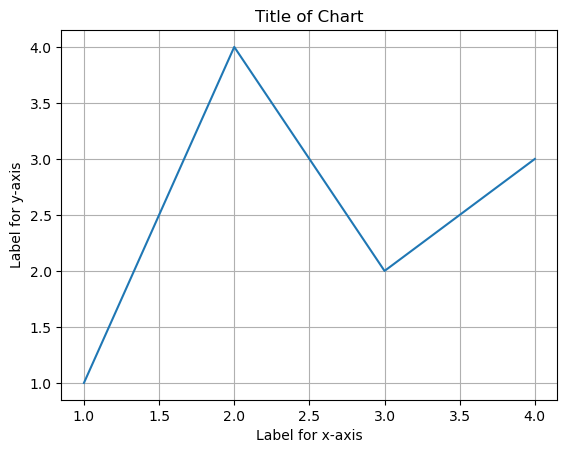

In [8]:
plot_line_chart.invoke(
    input={
        "x": [1, 2, 3, 4], 
        "y": [1, 4, 2, 3],
        "title": "Title of Chart",
        "x_label": "Label for x-axis",
        "y_label": "Label for y-axis",
    }
)

## Create graph

After we've defined the tools for the agents, we'll create the agents and tell them how to talk to each other using LangGraph.

### Define State

First define the state of the graph. This will just be a list of messages, and a key to track the most recent sender.

In [9]:
import operator
from typing import (
    Annotated, 
    Sequence, 
    TypedDict
)


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each 
# agent and tool.
class AgentState(TypedDict):
    messages: Annotated[
        Sequence[BaseMessage], 
        operator.add
    ]
    sender: str

### Define Agent Nodes

Next, let's define the nodes for the agents. To make things easier, we'll create a helper function to create a node for a given agent.

In [14]:
from typing import Any

from langchain_core.messages import AIMessage
from langchain_core.runnables import Runnable
from langchain.pydantic_v1 import BaseModel


def agent_node(
    state: AgentState, 
    agent: Runnable, 
    name: str
) -> AgentState:
    """
    Create a node on the graph for a given agent.

    Args:
        state: Current state of the graph.
        agent: The agent that can be invoked to get a result.
        name: The name of the node in the graph.
        
    Returns:
        New state of the graph.
    """
    result: [ToolMessage | BaseModel] = agent.invoke(state)
    
    # Convert the agent output into a format that 
    # is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:        
        result_dict = result.dict(
            exclude={"type", "name"}
        )
        result = AIMessage(
            **result_dict, 
            name=name
        )

    return AgentState(
        messages=[result],
        
        # Keep track of the agent that sent 
        # the most recent message, so that we 
        # know who to route to next.
        sender=name,
    )

Create the chat model (LLM) that will power the agents:

In [15]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0,
)

#### Research Agent

Create the research agent and its node in the graph. The research agent is responsible for searching for answers on the web using the provided web search tool.

In [17]:
from functools import partial

research_agent = create_agent(
    model=llm,
    tools=[web_search_tool],
    system_message=(
        "Given the user's query, your task is to use "
        "the provided tool to search the web for "
        "relevant answers. Provide accurate data "
        "for another AI assistant to plot a chart."
    ),
)
research_agent_node = partial(
    agent_node, 
    agent=research_agent, 
    name="researcher"
)

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


#### Chart Generator Agent

Create the chart generator agent and its node in the graph. Given the relevant data, the chart generator agent will plot a chart with the provided function/tool.

In [18]:
chart_agent = create_agent(
    model=llm,
    tools=[plot_line_chart],
    system_message=(        
        "Given the relevant data, use the provided "
        "tool to plot a chart of the data."
    )
)
chart_agent_node = partial(
    agent_node, 
    agent=chart_agent, 
    name="chart_generator"
)

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
